## DSCI 100 Project Proposal Team 44

Melanie Law, 98162993

# Project Title: Determining The Best Predictors Heart Disease

## Introduction

## Preliminary Data Analysis

In [16]:
#install.packages("corrplot")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [17]:
#Loading relevant libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(corrplot)

corrplot 0.92 loaded



In [6]:
#Loading and formatting the data

data <- read_delim("processed.cleveland.data", delim =",", col_names = FALSE)

attributes <-  c("age", 'sex','cp', 'trestbps', 'chol', 'fbs', 'restecg',
                 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num')
colnames(data) <- attributes

head(data)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [8]:
#Determining if the data has NA values
na_count <-sapply(data, function(y) sum(length(which(is.na(y)))))
na_count <- data.frame(na_count)
na_count

,na_count
,<int>
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0


In [9]:
#Note: the columns ca and thal load as character types as they contain non-numeric values.
#R does this as default to preserve information. Convert to numeric types then filter to remove NA values 

data <- data %>%
  mutate(oldpeak = as.numeric(oldpeak),
         ca = as.numeric(ca),
         thal = as.numeric(thal)) %>% 
  filter(!is.na(ca),
         !is.na(thal))


Warning message:
“Problem with `mutate()` input `ca`.
ℹ NAs introduced by coercion
ℹ Input `ca` is `as.numeric(ca)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `thal`.
ℹ NAs introduced by coercion
ℹ Input `thal` is `as.numeric(thal)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


In [10]:
# Split dataset into training/testing --------------------------------------

heart_split <- initial_split(data, prop = 0.8, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train_explore <- heart_train %>% 
  mutate(disease = ifelse(num > 0,"disease","healthy")) %>% 
  mutate(sex_char = ifelse(sex == 1 ,"male","female"))

In [14]:
# Exploratory Tables ------------------------------------------------------
heart_proportions <- heart_train %>% 
  group_by(num) %>% 
  summarize(n = n()) %>% 
  mutate(percent = 100*n/nrow(heart_train))%>%
  rename("disease" = num,
         "count" = n)
heart_proportions

heart_proportions_2 <- heart_train_explore %>% 
  group_by(disease) %>% 
  summarize(n = n()) %>% 
  mutate(percent = 100*n/nrow(heart_train_explore))%>%
  rename("status" = disease,
         "count" = n)
heart_proportions_2

summary <- heart_train %>%
  pivot_longer(everything()) %>%
  arrange(name) %>%
  group_by(name) %>%
  summarize(
    mean = mean(value),
    std_dev = sd(value),
    median = median(value),
    max = max(value),
    min = min(value),
    quartile.1 = quantile(value, 0.25),
    quartile.3 = quantile(value, 0.75)) %>%
  rename("predictor" = name)
summary

#Correlation matrix
cor_hr <- heart_train_explore %>% 
  select(-c(age, disease, num, sex_char)) %>% 
  cor()
round(cor_hr,2)

num_char <- heart_train_explore %>% 
  select(disease, num, sex, sex_char, age) %>% 
  group_by(num, sex_char) %>% 
  summarise(n = n())

#Export dataframes
# write.table(summary, file = "heart_summary_stats.csv", row.names = FALSE)
# write.table(heart_proportions, file = "strata_num.csv",row.names = FALSE)
# write.table(heart_proportions_2, file = "strata_num_consolidated.csv",row.names = FALSE)

`summarise()` ungrouping output (override with `.groups` argument)



disease,count,percent
<dbl>,<int>,<dbl>
0,128,53.33333
1,44,18.33333
2,28,11.66667
3,28,11.66667
4,12,5.00000


`summarise()` ungrouping output (override with `.groups` argument)



status,count,percent
<chr>,<int>,<dbl>
disease,112,46.66667
healthy,128,53.33333


`summarise()` ungrouping output (override with `.groups` argument)



predictor,mean,std_dev,median,max,min,quartile.1,quartile.3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age,54.7375000,9.0119545,56.0,77.0,29,48.00,61.25
ca,0.6708333,0.9351254,0.0,3.0,0,0.00,1.00
chol,249.9333333,52.1054183,246.0,564.0,126,213.75,281.25
cp,3.1833333,0.9549110,3.0,4.0,1,3.00,4.00
exang,0.3208333,0.4677724,0.0,1.0,0,0.00,1.00
fbs,0.1333333,0.3406451,0.0,1.0,0,0.00,0.00
num,0.9666667,1.2538365,0.0,4.0,0,0.00,2.00
oldpeak,1.0700000,1.2092461,0.8,6.2,0,0.00,1.80
restecg,1.0000000,0.9937040,1.0,2.0,0,0.00,2.00


,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
sex,1.00,0.00,-0.06,-0.20,0.00,0.05,-0.06,0.18,0.10,0.04,0.09,0.38
cp,0.00,1.00,-0.05,0.07,-0.13,0.04,-0.33,0.39,0.21,0.16,0.23,0.23
trestbps,-0.06,-0.05,1.00,0.17,0.14,0.14,-0.02,0.07,0.17,0.11,0.10,0.16
chol,-0.20,0.07,0.17,1.00,0.00,0.20,0.00,0.05,0.09,0.01,0.14,-0.01
fbs,0.00,-0.13,0.14,0.00,1.00,0.05,0.02,-0.01,-0.02,-0.04,0.14,0.01
restecg,0.05,0.04,0.14,0.20,0.05,1.00,-0.08,0.05,0.13,0.13,0.16,-0.01
thalach,-0.06,-0.33,-0.02,0.00,0.02,-0.08,1.00,-0.40,-0.35,-0.43,-0.25,-0.27
exang,0.18,0.39,0.07,0.05,-0.01,0.05,-0.40,1.00,0.29,0.27,0.18,0.34
oldpeak,0.10,0.21,0.17,0.09,-0.02,0.13,-0.35,0.29,1.00,0.62,0.33,0.35
slope,0.04,0.16,0.11,0.01,-0.04,0.13,-0.43,0.27,0.62,1.00,0.17,0.28


`summarise()` regrouping output by 'num' (override with `.groups` argument)



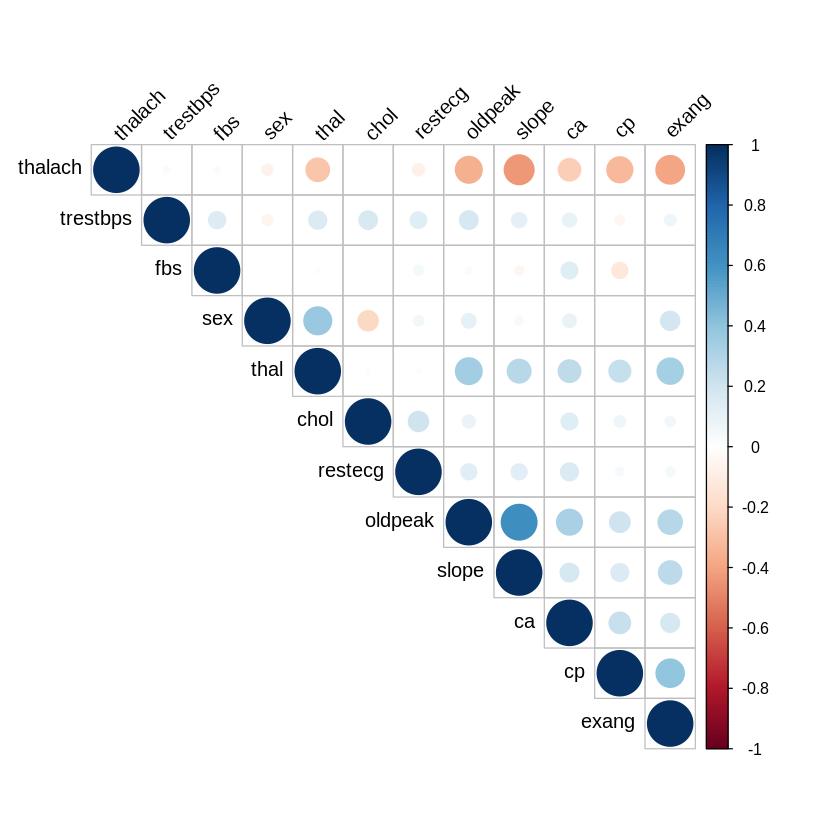

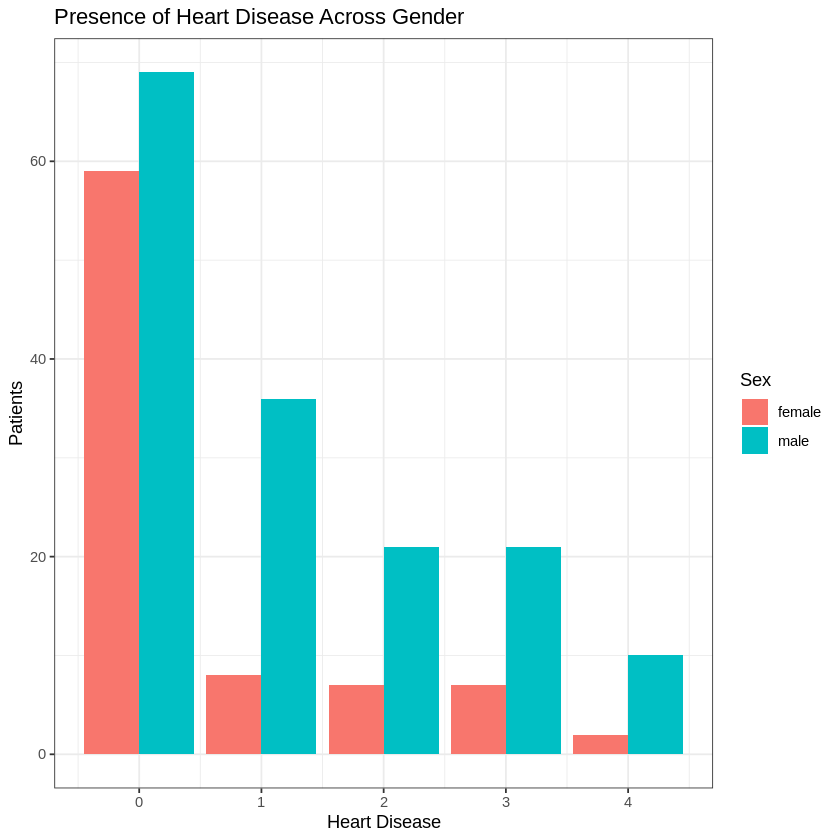

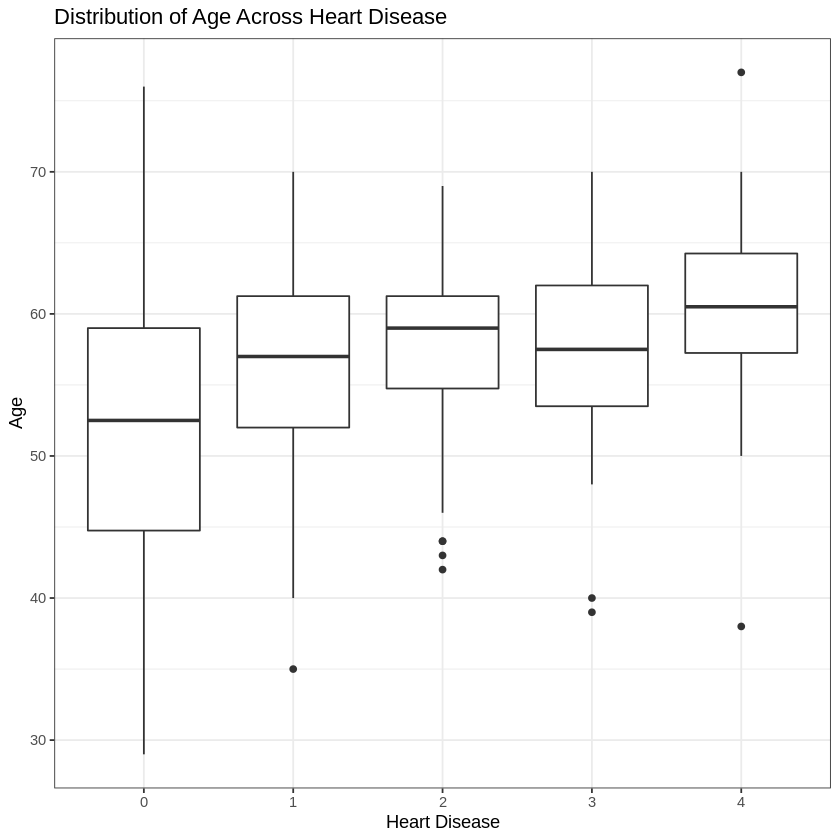

In [21]:
# Visualizations ----------------------------------------------------------
#Correlation matrix plot
corrplot(cor_hr, type = "upper", order = "hclust", 
         tl.col = "black", tl.srt = 45)

#Grouped barchart for sex vs heart disease
sex_bar_plot <- num_char %>% 
  ggplot(aes(x = num, y = n, fill = sex_char))+
  geom_bar(position="dodge", stat="identity")+
  labs(x = "Heart Disease", y = "Patients", fill = "Sex")+
  theme_bw()+
  ggtitle("Presence of Heart Disease Across Gender")
sex_bar_plot

#age box plot
age_box_plot <- heart_train_explore %>% 
  ggplot(aes(x= as.factor(num), y = age))+
  geom_boxplot()+
  labs(x = "Heart Disease", y = "Age")+
  theme_bw()+
  ggtitle("Distribution of Age Across Heart Disease")
age_box_plot